# SHL Dataset Analysis

In [ ]:
# Define some helper utilities

import re
import zipfile
import tempfile
import pathlib

import pandas as pd
import numpy as np


def slugify(s):
    s = str(s).strip().replace(' ', '_').lower()
    return re.sub(r'(?u)[^-\w.]', '', s)


shl_dataset_label_order = [
    'Null',
    'Still',
    'Walking',
    'Run',
    'Bike',
    'Car',
    'Bus',
    'Train',
    'Subway',
]


class SHLDataset:
    def __init__(
        self,
        acc_x, acc_y, acc_z,
        acc_mag,
        mag_x, mag_y, mag_z,
        mag_mag,
        gyr_x, gyr_y, gyr_z,
        gyr_mag,
        labels
    ):
        self.acc_x = acc_x
        self.acc_y = acc_y
        self.acc_z = acc_z
        self.acc_mag = acc_mag

        self.mag_x = mag_x
        self.mag_y = mag_y
        self.mag_z = mag_z
        self.mag_mag = mag_mag

        self.gyr_x = gyr_x
        self.gyr_y = gyr_y
        self.gyr_z = gyr_z
        self.gyr_mag = gyr_mag
        
        self.labels = labels


def load_shl_dataset(dataset_dir: pathlib.Path):
    acc_x = pd.read_csv(dataset_dir / 'Acc_x.txt', header=None, sep=' ').to_numpy()
    print('Acc_x Import Done')
    acc_y = pd.read_csv(dataset_dir / 'Acc_y.txt', header=None, sep=' ').to_numpy()
    print('Acc_y Import Done')
    acc_z = pd.read_csv(dataset_dir / 'Acc_z.txt', header=None, sep=' ').to_numpy()
    print('Acc_z Import Done')
    acc_mag = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
    print('Acc_mag Import Done')

    mag_x = pd.read_csv(dataset_dir / 'Mag_x.txt', header=None, sep=' ').to_numpy()
    print('Mag_x Import Done')
    mag_y = pd.read_csv(dataset_dir / 'Mag_y.txt', header=None, sep=' ').to_numpy()
    print('Mag_y Import Done')
    mag_z = pd.read_csv(dataset_dir / 'Mag_z.txt', header=None, sep=' ').to_numpy()
    print('Mag_z Import Done')
    mag_mag = np.sqrt(mag_x**2 + mag_y**2 + mag_z**2)
    print('Mag_mag Import Done')

    gyr_x = pd.read_csv(dataset_dir / 'Gyr_x.txt', header=None, sep=' ').to_numpy()
    print('Gyr_x Import Done')
    gyr_y = pd.read_csv(dataset_dir / 'Gyr_y.txt', header=None, sep=' ').to_numpy()
    print('Gyr_y Import Done')
    gyr_z = pd.read_csv(dataset_dir / 'Gyr_z.txt', header=None, sep=' ').to_numpy()
    print('Gyr_z Import Done')
    gyr_mag = np.sqrt(gyr_x**2 + gyr_y**2 + gyr_z**2)
    print('Gyr_mag Import Done')

    labels = pd.read_csv(dataset_dir / 'Label.txt', header=None, sep=' ').mode(axis=1).to_numpy().flatten()
    print('Labels Import Done')

    return SHLDataset(
        acc_x, acc_y, acc_z,
        acc_mag,
        mag_x, mag_y, mag_z, 
        mag_mag,
        gyr_x, gyr_y, gyr_z, 
        gyr_mag,
        labels
    )


def load_zipped_shl_dataset(zip_dir: pathlib.Path, tqdm=None):
    with tempfile.TemporaryDirectory() as unzip_dir:
        with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
            if tqdm:
                for member in tqdm(zip_ref.infolist(), desc=f'Extracting {zip_dir}'):
                    zip_ref.extract(member, unzip_dir)
            else:
                zip_ref.extractall(unzip_dir)

        train_dir = pathlib.Path(unzip_dir) / 'train'
        sub_dirs = [x for x in train_dir.iterdir() if train_dir.is_dir()]
        assert len(sub_dirs) == 1
        return load_shl_dataset(train_dir / sub_dirs[0])

In [1]:
import pathlib

from tqdm.notebook import tqdm

dataset = load_zipped_shl_dataset(pathlib.Path('shl-dataset/challenge-2020-train_hand.zip'), tqdm=tqdm)

Extracting shl-dataset\challenge-2020-train_hand.zip:   0%|          | 0/23 [00:00<?, ?it/s]

Acc_x Import Done
Acc_y Import Done
Acc_z Import Done
Acc_mag Import Done
Mag_x Import Done
Mag_y Import Done
Mag_z Import Done
Mag_mag Import Done
Gyr_x Import Done
Gyr_y Import Done
Gyr_z Import Done
Gyr_mag Import Done
Labels Import Done


In [2]:
# Plot some useful information about the data we just loaded
from collections import OrderedDict

sensor_groups = OrderedDict({
    'Akzelerometer': OrderedDict({
        'X-Achse': dataset.acc_x,
        'Y-Achse': dataset.acc_y,
        'Z-Achse': dataset.acc_z,
        'Vektorbetrag': dataset.acc_mag,
    }),
    'Magnetometer': OrderedDict({
        'X-Achse': dataset.mag_x,
        'Y-Achse': dataset.mag_y,
        'Z-Achse': dataset.mag_z,
        'Vektorbetrag': dataset.mag_mag,
    }),
    'Gyrosensor': OrderedDict({
        'X-Achse': dataset.gyr_x,
        'Y-Achse': dataset.gyr_y,
        'Z-Achse': dataset.gyr_z,
        'Vektorbetrag': dataset.gyr_mag
    }),
})

<Figure size 432x288 with 0 Axes>

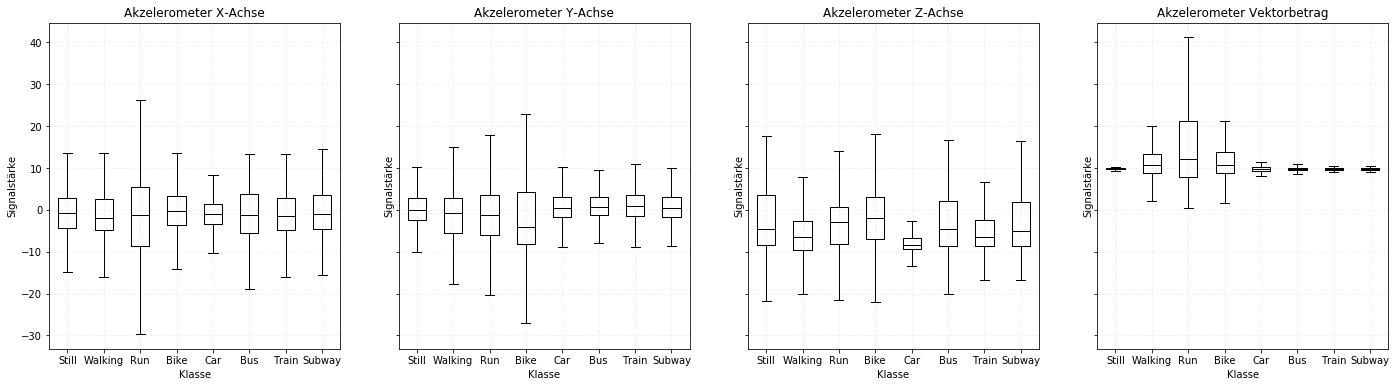

<Figure size 432x288 with 0 Axes>

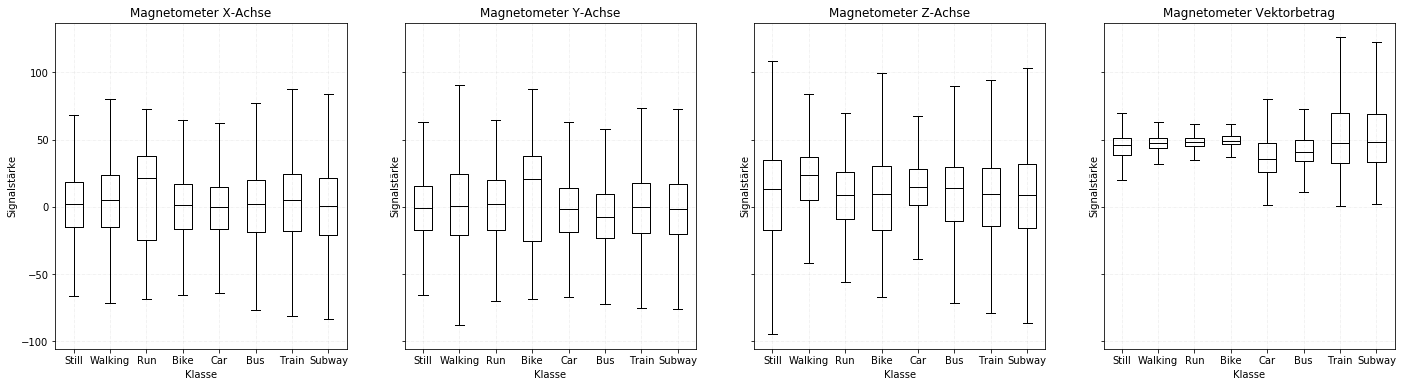

<Figure size 432x288 with 0 Axes>

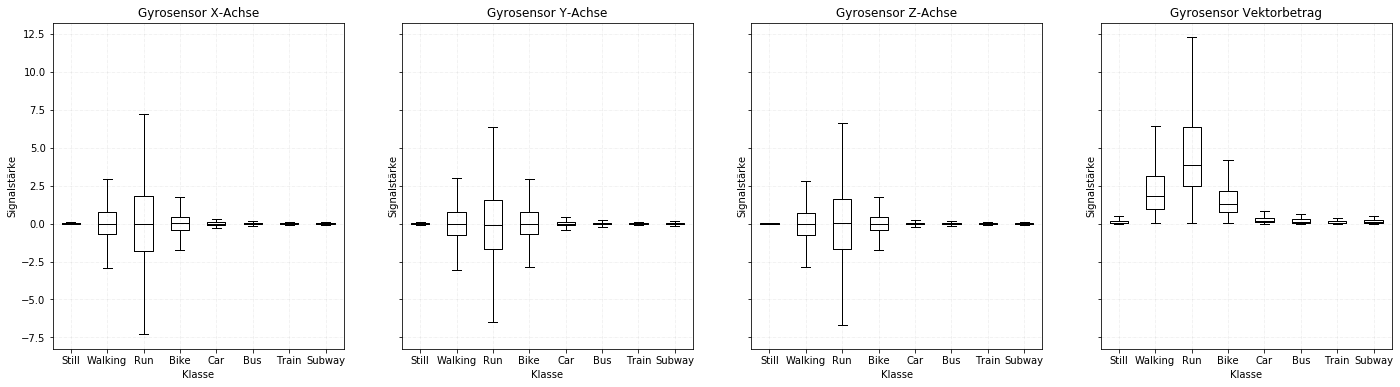

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convenience function to make boxplots black and white
def decolorize_boxplot(boxplot):
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(boxplot[element], color='black')

# Plot boxplots of the individual sensor groups
for group_name, sensor_dict in sensor_groups.items():
    plt.clf() # Clear current figure to prepare for new one
    fig, axs = plt.subplots(1, len(sensor_dict), sharey=True)
    fig.set_size_inches(6 * len(sensor_dict), 6)

    for i, (dimension_name, dimension_values) in enumerate(sensor_dict.items()):
        # Group values together with labels
        labels_df = pd.DataFrame(dataset.labels, columns=['label'])
        values_df = pd.DataFrame(dimension_values)
        labels_values_df = pd.concat([labels_df, values_df], axis=1)
        values_by_label = labels_values_df \
            .groupby(['label'])[0] \
            .apply(np.hstack) \
            .to_frame() \
            .reset_index()
        diagram_labels = values_by_label['label'].to_numpy()
        diagram_values = values_by_label[0].to_numpy()

        bp = axs[i].boxplot(diagram_values, showfliers=False)
        axs[i].set_xticks(range(1, len(shl_dataset_label_order)))
        axs[i].set_xticklabels(shl_dataset_label_order[1:])
        axs[i].set_title(f'{group_name} {dimension_name}')
        axs[i].grid(
            b = True, 
            color ='grey',
            linestyle ='-.', 
            linewidth = 0.5,
            alpha = 0.2
        )
        axs[i].set_ylabel('Signalstärke')
        axs[i].set_xlabel('Klasse')
        decolorize_boxplot(bp)   

    plt.savefig(
        f'../images/shl/{slugify(group_name)}-boxplot.pdf',
        dpi=1200,
        bbox_inches='tight'
    )
    plt.show()

<Figure size 432x288 with 0 Axes>

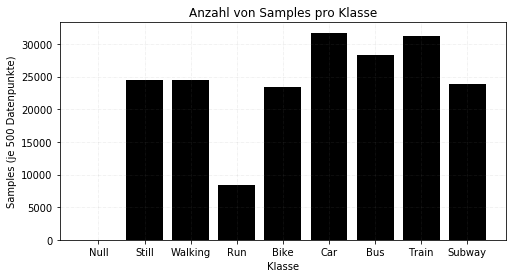

In [4]:
# Find out how much data we have for each label in total
plt.clf()
fig, ax = plt.subplots(figsize=(8, 4))
bins = np.bincount(dataset.labels)
bp = ax.bar(shl_dataset_label_order, bins, color='black')
ax.grid(
    b = True, 
    color ='grey',
    linestyle ='-.', 
    linewidth = 0.5,
    alpha = 0.2
)
ax.set_ylabel('Samples (je 500 Datenpunkte)')
ax.set_xlabel('Klasse')
ax.set_title('Anzahl von Samples pro Klasse')
plt.savefig(
    f'../images/shl/label-quantities.pdf',
    dpi=1200,
    bbox_inches='tight'
)
plt.show()

<Figure size 432x288 with 0 Axes>

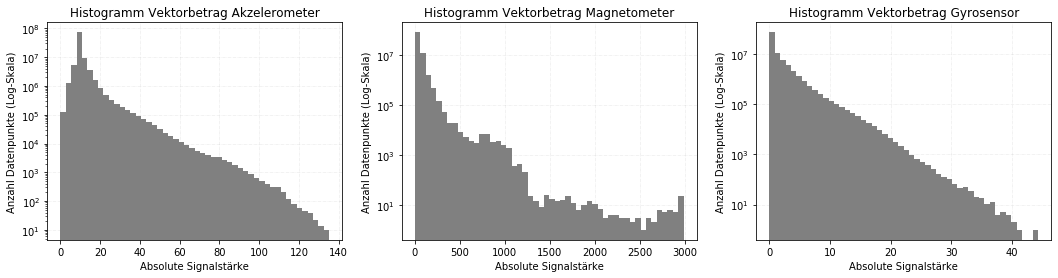

In [20]:
# Plot histograms of the sensors' data

plt.clf()

sensors_magnitudes = [
    ('Akzelerometer', dataset.acc_mag),
    ('Magnetometer', dataset.mag_mag),
    ('Gyrosensor', dataset.gyr_mag)
]

fig, axs = plt.subplots(1, len(sensors_magnitudes))
fig.set_size_inches(6 * len(sensors_magnitudes), 4)

for i, (sensor_name, magnitudes) in enumerate(sensors_magnitudes):
    flattened_samples = magnitudes.flatten()
    axs[i].hist(flattened_samples, bins=50, color='grey')
    axs[i].grid(
        b = True, 
        color ='grey',
        linestyle ='-.', 
        linewidth = 0.5,
        alpha = 0.2
    )
    axs[i].set_yscale('log')
    axs[i].set_title(f'Histogramm Vektorbetrag {sensor_name}')
    axs[i].set_xlabel('Absolute Signalstärke')
    axs[i].set_ylabel('Anzahl Datenpunkte (Log-Skala)')

plt.savefig(
    f'../images/shl/sensor-histograms.pdf',
    dpi=1200,
    bbox_inches='tight'
)
plt.show()


In [21]:
# Visualize different scalers for acc_mag

from sklearn.preprocessing import StandardScaler, PowerTransformer

scalers_magnitudes = [
    ('Standardisierung', StandardScaler().fit_transform(dataset.acc_mag)),
    ('Yeo-Johnson Transformation', PowerTransformer().fit_transform(dataset.acc_mag)),
    ('Box-Cox Transformation', PowerTransformer(method='box-cox').fit_transform(dataset.acc_mag)),
]

<Figure size 432x288 with 0 Axes>

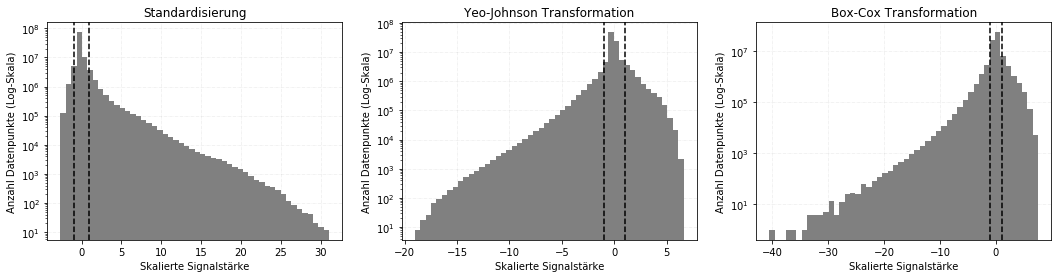

In [22]:

plt.clf()

fig, axs = plt.subplots(1, len(scalers_magnitudes))
fig.set_size_inches(6 * len(scalers_magnitudes), 4)

for i, (scaler_name, magnitudes) in enumerate(scalers_magnitudes):
    flattened_samples = magnitudes.flatten()
    axs[i].hist(flattened_samples, bins=50, color='grey')
    axs[i].grid(
        b = True, 
        color ='grey',
        linestyle ='-.', 
        linewidth = 0.5,
        alpha = 0.2
    )
    axs[i].axvline(x=-1, color='black', linestyle='--')
    axs[i].axvline(x=1, color='black', linestyle='--')
    axs[i].set_yscale('log')
    axs[i].set_title(f'{scaler_name}')
    axs[i].set_xlabel('Skalierte Signalstärke')
    axs[i].set_ylabel('Anzahl Datenpunkte (Log-Skala)')

plt.savefig(
    f'../images/shl/scaler-histograms.pdf',
    dpi=1200,
    bbox_inches='tight'
)
plt.show()

In [23]:
# Visualize box-cox for acc_mag, mag_mag and gyr_mag

scalers_magnitudes = [
    ('Vektorbetrag Akzelerometer', PowerTransformer().fit_transform(dataset.acc_mag)),
    ('Vektorbetrag Magnetometer', PowerTransformer().fit_transform(dataset.mag_mag)),
    ('Vektorbetrag Gyrosensor', PowerTransformer().fit_transform(dataset.gyr_mag)),
]

<Figure size 432x288 with 0 Axes>

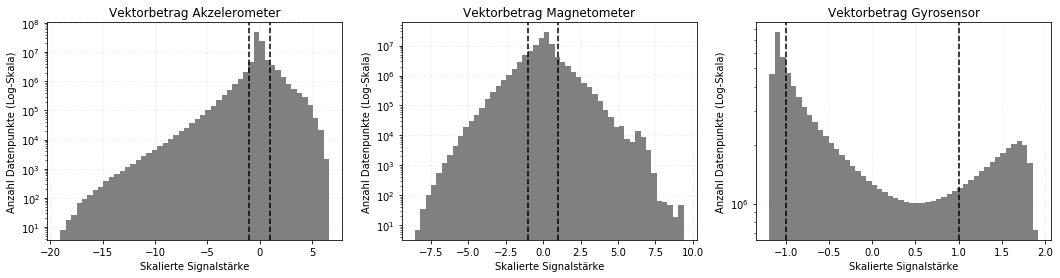

In [24]:
plt.clf()

fig, axs = plt.subplots(1, len(scalers_magnitudes))
fig.set_size_inches(6 * len(scalers_magnitudes), 4)

for i, (scaler_name, magnitudes) in enumerate(scalers_magnitudes):
    flattened_samples = magnitudes.flatten()
    axs[i].hist(flattened_samples, bins=50, color='grey')
    axs[i].grid(
        b = True, 
        color ='grey',
        linestyle ='-.', 
        linewidth = 0.5,
        alpha = 0.2
    )
    axs[i].axvline(x=-1, color='black', linestyle='--')
    axs[i].axvline(x=1, color='black', linestyle='--')
    axs[i].set_yscale('log')
    axs[i].set_title(f'{scaler_name}')
    axs[i].set_xlabel('Skalierte Signalstärke')
    axs[i].set_ylabel('Anzahl Datenpunkte (Log-Skala)')

plt.savefig(
    f'../images/shl/yeo-johnson-histograms.pdf',
    dpi=1200,
    bbox_inches='tight'
)
plt.show()

{1: 1.0021671573438011, 2: 0.9985739895697523, 3: 2.8994439843842423, 4: 1.044135815617944, 5: 0.7723505499007343, 6: 0.8652474758172704, 7: 0.7842127155793044, 8: 1.0283208861290594}


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

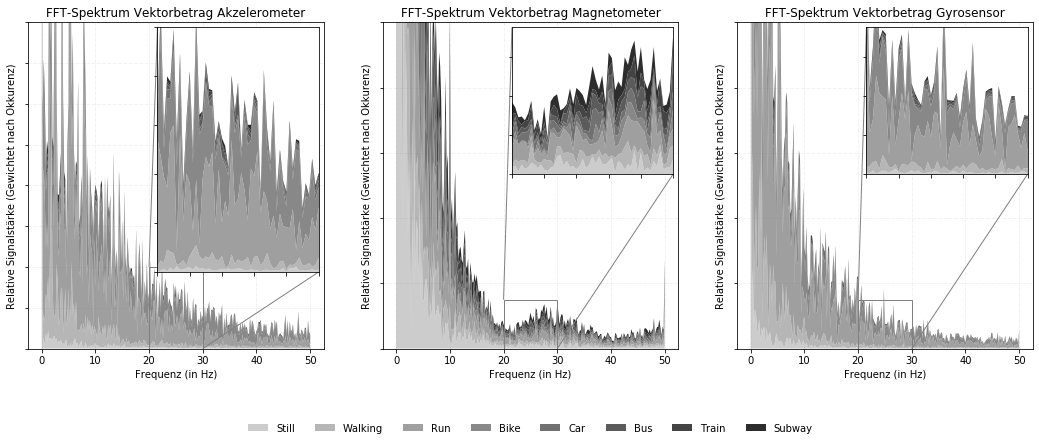

In [25]:
# Plot frequency spectrum of each sensor

from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from sklearn.utils.class_weight import compute_class_weight

plt.clf()

fig, axs = plt.subplots(1, len(sensors_magnitudes))
fig.set_size_inches(6 * len(sensors_magnitudes), 6)

class_weights = compute_class_weight('balanced', classes=np.unique(dataset.labels), y=dataset.labels)
class_weights = dict(zip(np.unique(dataset.labels), class_weights)) # Keras adaption
print(class_weights)

area_confs = [
    {'y_max': 200000, 'zoom_x_min': 20, 'zoom_x_max': 30, 'zoom_y_min': 0, 'zoom_y_max': 50000},
    {'y_max': 50000, 'zoom_x_min': 20, 'zoom_x_max': 30, 'zoom_y_min': 0, 'zoom_y_max': 7500},
    {'y_max': 50000, 'zoom_x_min': 20, 'zoom_x_max': 30, 'zoom_y_min': 0, 'zoom_y_max': 7500}
]

for i, (sensor_name, magnitudes) in enumerate(sensors_magnitudes):
    plot_y = []
    plot_x = np.fft.rfftfreq(500, d=0.01)

    for label_id in tqdm(range(1, len(shl_dataset_label_order))):
        balance = class_weights[label_id]

        combined_Y = None
        for sample_label_id, sample in zip(dataset.labels, magnitudes):
            if sample_label_id != label_id:
                continue # Only check samples with the wanted label
            if combined_Y is None:
                combined_Y = np.fft.rfft(sample) * balance
            else:
                combined_Y += np.fft.rfft(sample) * balance
        plot_y.append(np.abs(combined_Y))

    min_pct = 20
    max_pct = 100
    colors = [plt.cm.binary(pct / 100) for pct in np.arange(min_pct, max_pct, (max_pct - min_pct) / len(shl_dataset_label_order))]
    axs[i].stackplot(plot_x, *plot_y, labels=shl_dataset_label_order[1:], colors=colors, baseline='zero')
    axs[i].grid(
        b = True, 
        color ='grey',
        linestyle ='-.', 
        linewidth = 0.5,
        alpha = 0.2
    )
    axs[i].set_ylim(0, area_confs[i]['y_max'])
    axs[i].set_title(f'FFT-Spektrum Vektorbetrag {sensor_name}')
    axs[i].set_xlabel('Frequenz (in Hz)')
    axs[i].set_yticklabels([])
    axs[i].set_ylabel('Relative Signalstärke (Gewichtet nach Okkurenz)')

    axins = zoomed_inset_axes(axs[i], 3, loc=1)
    axins.stackplot(plot_x, *plot_y, labels=shl_dataset_label_order[1:], colors=colors, baseline='zero')
    axins.set_xlim(area_confs[i]['zoom_x_min'], area_confs[i]['zoom_x_max'])
    axins.set_xticklabels([])
    axins.set_ylim(area_confs[i]['zoom_y_min'], area_confs[i]['zoom_y_max'])
    axins.set_yticklabels([])
    mark_inset(axs[i], axins, loc1=2, loc2=4, fc='none', ec='0.5')

axs[1].legend(loc='upper center', frameon=False, bbox_to_anchor=(0.5, -0.2), ncol=len(shl_dataset_label_order[1:]))

plt.savefig(
    f'../images/shl/sensor-fft.pdf',
    dpi=1200,
    bbox_inches='tight'
)
plt.show()
